In [1]:
#!nvidia-smi

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
import os.path
from os import path
import re
from distutils.version import LooseVersion
import warnings
from sklearn.preprocessing import OneHotEncoder
import pickle
import sys
import itertools

In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
%cd '/content/drive/MyDrive/Project_DevC'
!ls

/content/drive/MyDrive/Project_DevC
 clone_cmt_tiki		    Data_Preprocessing.ipynb
 clone_data		    model.h5
 Data_Bank100518.txt	    scrapingweb_bookingcomment.ipynb
 Data_ChungKhoan14518.txt  'Script - SơnNT.docx'
 Data_chungkhoan_duc.csv    Sentiment_Analysis.ipynb
 data_dep.csv		    Sentiment_LSTM.ipynb
 datadepvail.csv	    Untitled10.ipynb
 data.pkl		   'Xử lí dữ liệu + LSTM.pptx'


In [5]:
data = pd.read_csv("Data_chungkhoan_duc.csv")
data

,Unnamed: 0,text,label
0,0,Fpt tăng đẹp quá. Kk,2
1,1,Tch tăng trần 2 phiên sau tin này rồi,2
2,2,Em bổ xung KBC vào danh mục khuyến nghị mua nh...,2
3,3,Cvt tiếp tục tăng tốt,2
4,4,HCM giảm mạnh rồi :D,0
...,...,...,...
5457,5457,Dịch vụ này kém hơn dịch vụ của ngân hàng BIDV,0
5458,5458,Chúng tôi mong muốn lãi xuất cao hơn,2
5459,5459,Thái độ phục vụ của nhân viên kém ấn tượng,0
5460,5460,Thông tin xấu trên mạng xã hội ảnh hưởng nghiê...,0


In [6]:
data = data.drop(['Unnamed: 0'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462 entries, 0 to 5461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5462 non-null   object
 1   label   5462 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.5+ KB


In [7]:
data = data.dropna() 

In [8]:
data['label'].value_counts()

1    3569
2    1282
0     611
Name: label, dtype: int64

In [9]:
data.drop_duplicates(subset= ['text'] )

,text,label
0,Fpt tăng đẹp quá. Kk,2
1,Tch tăng trần 2 phiên sau tin này rồi,2
2,Em bổ xung KBC vào danh mục khuyến nghị mua nh...,2
3,Cvt tiếp tục tăng tốt,2
4,HCM giảm mạnh rồi :D,0
...,...,...
5457,Dịch vụ này kém hơn dịch vụ của ngân hàng BIDV,0
5458,Chúng tôi mong muốn lãi xuất cao hơn,2
5459,Thái độ phục vụ của nhân viên kém ấn tượng,0
5460,Thông tin xấu trên mạng xã hội ảnh hưởng nghiê...,0


In [10]:
#data.to_csv('data_dep.csv', index= None)

In [11]:
# Hyperparameters
max_sentence_length = 200
embedding_vector_length = 300
dropout = 0.5

In [12]:
def process_sentence(sentence):
    # Loai bo cac ki tu dac biet, chuyen cau ve lower case
    return re.sub(r'[\\\\/:*«`\'?¿";!<>,|]', '', sentence.lower().strip())

In [13]:
def create_lookup_tables(text):
    # Tao bang tra cuu Vocab
    #:param text: Text duoc chia nho thanh cac word
    #:return:  (vocab_to_int, int_to_vocab)

    vocab = set(text)

    vocab_to_int = {word: i for i, word in enumerate(vocab)}
    int_to_vocab = {v: k for k, v in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab

In [14]:
def convert_to_int(data, data_int):
    # Chuyen doi text thanh vector so
    all_items = []
    for sentence in data:
        all_items.append([data_int[word] if word in data_int else data_int["<UNK>"] for word in sentence.split()])

    return all_items

In [15]:
def load_data():
    # Ham load du lieu tu file csv
    data = pd.read_csv("Data_chungkhoan_duc.csv")
    print(data.describe())
    return data

In [16]:
def get_model():
    # Ham tao model
    model = Sequential()

    model.add(Embedding(len(vocab_to_int), embedding_vector_length, input_length=max_sentence_length))
    model.add(LSTM(256, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
    model.add(LSTM(256, dropout=dropout, recurrent_dropout=dropout))
    model.add(Dense(len(sentiment), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [17]:
def predict_sentence(model, sentence,  vocab_to_int, int_to_sentiment):
    # Chuyen text thanh vector int va dua vao model de predict sentiment

    # Clean the sentence
    sentence = process_sentence(sentence)

    # Transform and pad it before using the model to predict
    x = numpy.array(convert_to_int([sentence], vocab_to_int))
    x = sequence.pad_sequences(x, maxlen=max_sentence_length)

    prediction = model.predict(x)
    #print(prediction[0])

    # Get the highest prediction
    sentiment_index = numpy.argmax(prediction)
    print(prediction[0][sentiment_index])

    # Neu probality <0.3 thi hien thi ngon ngu Khong xac dinh/Unknown
    if prediction[0][sentiment_index]<0.3:
        return "Unknown"
    else:
        return int_to_sentiment[sentiment_index]

In [18]:
data = load_data()

# Xao tron data
sss = StratifiedShuffleSplit(test_size=0.15, random_state=42)

        Unnamed: 0        label
count  5462.000000  5462.000000
mean   2730.500000     1.122849
std    1576.887916     0.575800
min       0.000000     0.000000
25%    1365.250000     1.000000
50%    2730.500000     1.000000
75%    4095.750000     1.000000
max    5461.000000     2.000000


In [19]:
# Lam sach cau
X = data["text"].apply(process_sentence)
y = data["label"]

In [20]:
# Chia data thanh cac cau
elements = (' '.join([sentence for sentence in X])).split()

X_train, X_val, X_test, y_train, y_val, y_test = None, None, None, None, None, None

# Chia du lieu train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
for train_index, val_index in sss.split(X_train, y_train):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

In [22]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

3713
656
1093


In [23]:
# Lay danh sach cac sentiment
sentiment = set(y)

# Them word UNK cho cac word ko co trong vocab
elements.append("<UNK>")

# Chuyen vocab thanh vector so
vocab_to_int, int_to_vocab = create_lookup_tables(elements)
sentiment_to_int, int_to_sentiment = create_lookup_tables(y)

In [24]:
# Luu lai cac du lieu
with open("data.pkl", "wb") as fp:
  pickle.dump([vocab_to_int, int_to_vocab, sentiment_to_int, int_to_sentiment, sentiment] , fp)

In [25]:
# Encode du lieu X
X_test_encoded = convert_to_int(X_test, vocab_to_int)
X_train_encoded = convert_to_int(X_train, vocab_to_int)
X_val_encoded = convert_to_int(X_val, vocab_to_int)
# Encode du lieu Y
#y_data = convert_to_int(y_test, sentiment_to_int)

# Tao encode one hot
#enc = OneHotEncoder()
#enc.fit(y_data)

# Chuyen du lieu y thanh Encode
#y_train_encoded = enc.fit_transform(y_train, sentiment_to_int).toarray().reshape(-1,1)
#y_test_encoded = enc.fit_transform(y_test, sentiment_to_int).toarray()

y_train_encoded = np_utils.to_categorical(y_train, 3)
y_test_encoded = np_utils.to_categorical(y_test, 3)
y_val_encoded = np_utils.to_categorical(y_val, 3)

In [26]:
X_train_pad = sequence.pad_sequences(X_train_encoded, maxlen=max_sentence_length)
X_test_pad = sequence.pad_sequences(X_test_encoded, maxlen=max_sentence_length)
X_val_pad = sequence.pad_sequences(X_val_encoded, maxlen=max_sentence_length)

In [27]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          4463100   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 256)          570368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 5,559,551
Trainable params: 5,559,551
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train_pad, y_train_encoded, validation_data = (X_val_pad, y_val_encoded), epochs=5, batch_size=256)

Epoch 1/5
15/15 [==============================] - 31s 2s/step - loss: 0.8862 - accuracy: 0.6655 - val_loss: 0.8550 - val_accuracy: 0.6646
Epoch 2/5
15/15 [==============================] - 31s 2s/step - loss: 0.7396 - accuracy: 0.7107 - val_loss: 0.7189 - val_accuracy: 0.6966
Epoch 3/5
15/15 [==============================] - 30s 2s/step - loss: 0.5030 - accuracy: 0.8018 - val_loss: 0.6137 - val_accuracy: 0.7591
Epoch 4/5
15/15 [==============================] - 30s 2s/step - loss: 0.3537 - accuracy: 0.8653 - val_loss: 0.6139 - val_accuracy: 0.7774
Epoch 5/5
15/15 [==============================] - 30s 2s/step - loss: 0.2443 - accuracy: 0.9146 - val_loss: 0.6149 - val_accuracy: 0.7881


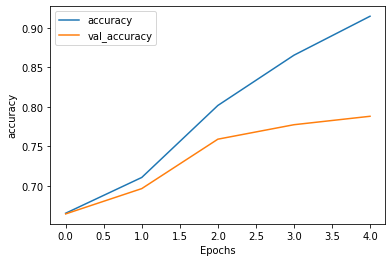

In [29]:
plot_graphs(history, 'accuracy')

In [30]:
scores = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.83%


In [31]:
y_pred = model.predict(X_test_pad)
y_pred= np.argmax(y_pred, axis=1)
y_test_encoded = np.argmax(y_test_encoded,axis = 1)

print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.50      0.62       123
           1       0.88      0.96      0.92       713
           2       0.85      0.79      0.82       257

    accuracy                           0.87      1093
   macro avg       0.85      0.75      0.79      1093
weighted avg       0.86      0.87      0.86      1093



In [32]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Hàm plot confusion matrix.
    Normalization được ấn định sẵn bằng True.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

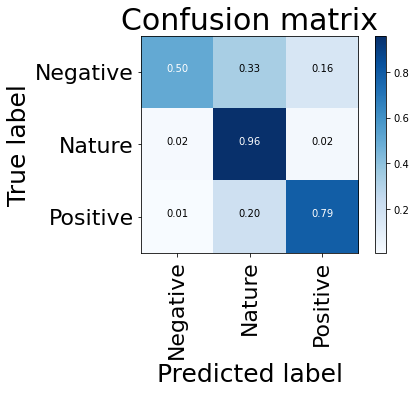

In [44]:
cnf_matrix = confusion_matrix(y_test_encoded, y_pred)

plot_confusion_matrix(cnf_matrix, classes = ["Negative","Nature","Positive"], title='Confusion matrix', cmap=plt.cm.Blues)

In [34]:
model.save("model.h5")